In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score
from sklearn.neighbors import KNeighborsClassifier
import pickle
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import numpy as np
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import PCA, TruncatedSVD

In [22]:
x_train = np.array(pickle.load(open('data/saved/train_x.sav','rb')))
y_train = np.array(pickle.load(open('data/saved/train_y.sav','rb')))
x_test = np.array(pickle.load(open('data/saved/test_x.sav','rb')))
y_test = np.array(pickle.load(open('data/saved/test_y.sav','rb')))


Vi sau khi tien xu li so chieu van con qua lon -> su dung PCA de giam so chieu  
Vi laptop deu k chay dc pca nen e chay tren google colab r luu lai vao file=)))))

In [24]:
feature_extractor = Pipeline([
    # Chuyển tập dữ liệu sang dạng vector count dựa trên một vocab chung (BoW), loại bỏ những word có tần suất xuất hiện > 0.8
    ('vectorize', CountVectorizer(max_df=0.8)),

    # Áp dụng TF-IDF để trích chọn đặc trưng (extract feature)
    ('feature extracter', TfidfTransformer()),
])
feature_extractor_pca = Pipeline([
    # Chuyển tập dữ liệu sang dạng vector count dựa trên một vocab chung (BoW), loại bỏ những word có tần suất xuất hiện > 0.8
    ('vectorize', CountVectorizer(max_df=0.8, encoding='utf-16')),

    # Áp dụng TF-IDF để trích chọn đặc trưng (extract feature)
    ('feature extracter', TfidfTransformer()),

    # Áp dụng Pricipal component analysis để giảm số chiều dữ liệu và vẫn dữ được các thông tin quan trọng cho phân loại
    ('pca', TruncatedSVD(n_components=3000)),
])
# train_feature = feature_extractor.fit_transform(x_train,y_train)
# train_features_pca = feature_extractor_pca.fit_transform(x_train,y_train)
# pickle.dump(feature_extractor,open('data/saved/feature_extractor.sav','wb'))
# pickle.dump(feature_extractor_pca,open('data/saved/feature_extractor_pca.sav','wb'))
# pickle.dump(train_feature,open('data/saved/train_feature.sav','wb'))
# pickle.dump(train_features_pca,open('data/saved/train_feature_pca.sav','wb'))
# print('Kích thước ma trận dữ liệu huấn luyện: ', train_feature.shape)

In [52]:
train_feature = pickle.load(open('data/saved/train_feature.sav','rb'))
train_features_pca = pickle.load(open('data/saved/train_features_pca.sav','rb'))

In [26]:
num_folds = 5
rstate = 1
spliter = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=rstate)

### 1.Phan lop bang KNN
KNN hoạt động dựa trên nguyên tắc rằng các điểm dữ liệu có thuộc tính giống nhau thường có cùng nhãn. Thuật toán này không tạo ra một mô hình dự đoán mà thay vào đó, khi có một điểm dữ liệu mới cần phân loại, nó tìm kiếm trong tập dữ liệu huấn luyện để xác định "K" điểm dữ liệu gần nhất (các "hàng xóm") và sau đó dự đoán nhãn của điểm dữ liệu mới dựa trên đa số nhãn của các điểm hàng xóm.
Các tham số chính trong thuật toán KNN bao gồm:
- K: Đây là số lượng hàng xóm gần nhất mà thuật toán sẽ xem xét để đưa ra dự đoán cho một điểm dữ liệu mới. Giá trị K này thường được chọn trước và có thể ảnh hưởng đến độ chính xác của mô hình.

- Hàm khoảng cách: Khi xác định các hàng xóm gần nhất, thuật toán cần một hàm để đo lường khoảng cách giữa các điểm dữ liệu. Hàm này thường là Euclidean distance, nhưng cũng có thể sử dụng các hàm khoảng cách khác tùy thuộc vào đặc điểm của dữ liệu.

- Trọng số của các hàng xóm: Trong một số trường hợp, các hàng xóm gần nhất có thể được coi là quan trọng hơn so với các hàng xóm xa hơn. Trong trường hợp này, trọng số có thể được gán cho mỗi hàng xóm dựa trên khoảng cách của chúng đến điểm dữ liệu mới.

- Tiêu chuẩn hóa dữ liệu: Trong một số trường hợp, việc tiêu chuẩn hóa dữ liệu có thể cần thiết để đảm bảo rằng các biến có phạm vi giá trị tương đương khi tính toán khoảng cách.


In [9]:
mean_accuracy_scores = []
mean_f1_scores = []
mean_train_time = []
mean_valid_time = []

K_neighbor = 10
for k in range(1,K_neighbor):
    model = KNeighborsClassifier(n_neighbors=k)
    accs = []
    f1s = []
    train_times = []
    valid_times = []
    for train_index, valid_index in spliter.split(x_train, y_train):
        # train model
        start = time.time_ns()
        model.fit(train_feature[train_index], y_train[train_index])
        train_times.append(time.time_ns() - start)

        # valid model
        start = time.time_ns()
        y_pred = model.predict(train_feature[valid_index])
        valid_times.append(time.time_ns() - start)

        # evaluate model
        accs.append(accuracy_score(y_train[valid_index], y_pred))
        f1s.append(f1_score(y_train[valid_index], y_pred, average='macro'))

    mean_train_time.append(np.mean(train_times))
    mean_valid_time.append(np.mean(valid_times))
    mean_accuracy_scores.append(np.mean(accs))
    mean_f1_scores.append(np.mean(f1s))
    print(f'Với K_neighbor = {k}:')
    print('\t - Thời gian train: {:.2f} ms'.format(mean_train_time[-1] / 1e6))
    print('\t - Thời gian valid: {:.2f} ms'.format(mean_valid_time[-1] / 1e6))
    print('\t - Accuracy score:  {:.2f} %'.format(mean_accuracy_scores[-1] * 100))
    print('\t - F1 score:        {:.2f} %'.format(mean_f1_scores[-1] * 100))

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=10)
knn_model.fit(train_feature,y_train)
path = 'data/saved/knn_model.sav'
pickle.dump(knn_model, open(path, 'wb'))

### 2. Logistic Regression
Hồi quy logistic là một kỹ thuật phân tích dữ liệu sử dụng toán học để tìm ra mối quan hệ giữa hai yếu tố dữ liệu. Sau đó, kỹ thuật này sử dụng mối quan hệ đã tìm được để dự đoán giá trị của những yếu tố đó dựa trên yếu tố còn lại. Dự đoán thường cho ra một số kết quả hữu hạn, như có hoặc không.
Hồi quy logistic là một mô hình thống kê sử dụng hàm logistic, hay hàm logit trong toán học làm phương trình giữa x và y. Hàm logit ánh xạ y làm hàm sigmoid của x.
Hàm sigmoid của x.
$$sigmoid(x) = \frac{1}{1 + e^{-x}}$$
Mô hình Logistic Regression có 3 siêu tham số cần chọn đó là phương pháp hiệu chỉnh, hệ số hiệu chỉnh và thuật toán tối ưu. Với mỗi thuật toán tối ưu sẽ hỗ trợ một số phương pháp hiệu chỉnh khác nhau. Trong đó:

Thuật toán tối ưu:
- Newton's method ('l2', 'none'): Thuật toán này cũng hướng tới việc xấp xỉ hàm loss bậc 2 tương tự như Gradient Descent, những khác ở chỗ nó sử dụng phép xấp xỉ bậc 2, tại mỗi bước nó sẽ xấp xỉ hàm số f(x) bằng 1 hàm số bậc 2 quanh x và tiến 1 bước về cực đại hoặc cực tiểu của hàm đó.
- Limited-memory Broyden–Fletcher–Goldfarb–Shanno Algorithm ('l2', 'none'): Tương tự như Newton's method nhưng ma trận Hessian được tính gần đúng bằng cách đánh giá đạo hàm. Phương pháp này rất tốt cho tập dữ liệu nhỏ.
- A Library for Large Linear Classification ('l1', 'l2'): Là một phương pháp linear classification mà hỗ trợ Logistic Regression và linear SVM
- Stochastic Average Gradient ('l2', 'none'): Phương pháp SAG thực hiện tối ưu hóa tổng của một số hữu hạn các hàm lồi trơn.
- SAGA ('elasticnet', 'l2', 'l1', 'none'): Là một biến thể của SAG nhưng hỗ trợ L1, nó hoạt động rất tốt với những bộ dữ liệu rất lớn.

Phương pháp hiệu chỉnh
- none: Không hiệu chỉnh
- l1: Hiệu chỉnh L1
- l2: Hiệu chỉnh L2
- elasticnet: Kết hợp giữa L1 và L2

Nghịch đảo của hệ số hiệu chỉnh (C) - C càng nhỏ, hiệu chỉnh càng mạnh:

$$C \in \{ 1, 2, 5, 10, 16 \}$$


In [ ]:
mean_accuracy_scores = []
mean_f1_scores = []
mean_train_time = []
mean_valid_time = []

opt_solve = ['newton-cg','lbfgs','liblinear','sag','saga']
MAX_ITER = 100_000
for opt in opt_solve:
    model = LogisticRegression(solver=opt,penalty='l2',C=2,max_iter=MAX_ITER)
    accs = []
    f1s = []
    train_times = []
    valid_times = []
    for train_index, valid_index in spliter.split(x_train, y_train):
        # train model
        start = time.time_ns()
        model.fit(train_feature[train_index], y_train[train_index])
        train_times.append(time.time_ns() - start)

        # valid model
        start = time.time_ns()
        y_pred = model.predict(train_feature[valid_index])
        valid_times.append(time.time_ns() - start)

        # evaluate model
        accs.append(accuracy_score(y_train[valid_index], y_pred))
        f1s.append(f1_score(y_train[valid_index], y_pred, average='macro'))

    mean_train_time.append(np.mean(train_times))
    mean_valid_time.append(np.mean(valid_times))
    mean_accuracy_scores.append(np.mean(accs))
    mean_f1_scores.append(np.mean(f1s))
    print(f'Với phuong phap hieu chinh = {opt}:')
    print('\t - Thời gian train: {:.2f} ms'.format(mean_train_time[-1] / 1e6))
    print('\t - Thời gian valid: {:.2f} ms'.format(mean_valid_time[-1] / 1e6))
    print('\t - Accuracy score:  {:.2f} %'.format(mean_accuracy_scores[-1] * 100))
    print('\t - F1 score:        {:.2f} %'.format(mean_f1_scores[-1] * 100))

Với phuong phap hieu chinh = newton-cg:
	 - Thời gian train: 102978.94 ms
	 - Thời gian valid: 45.15 ms
	 - Accuracy score:  88.34 %
	 - F1 score:        85.54 %
Với phuong phap hieu chinh = lbfgs:
	 - Thời gian train: 120514.90 ms
	 - Thời gian valid: 64.50 ms
	 - Accuracy score:  88.34 %
	 - F1 score:        85.54 %
Với phuong phap hieu chinh = liblinear:
	 - Thời gian train: 25859.14 ms
	 - Thời gian valid: 40.78 ms
	 - Accuracy score:  88.20 %
	 - F1 score:        85.26 %
Với phuong phap hieu chinh = sag:
	 - Thời gian train: 15210.95 ms
	 - Thời gian valid: 54.49 ms
	 - Accuracy score:  88.34 %
	 - F1 score:        85.54 %
Với phuong phap hieu chinh = saga:
	 - Thời gian train: 18629.61 ms
	 - Thời gian valid: 52.61 ms
	 - Accuracy score:  88.35 %
	 - F1 score:        85.55 %


Giữ nguyên

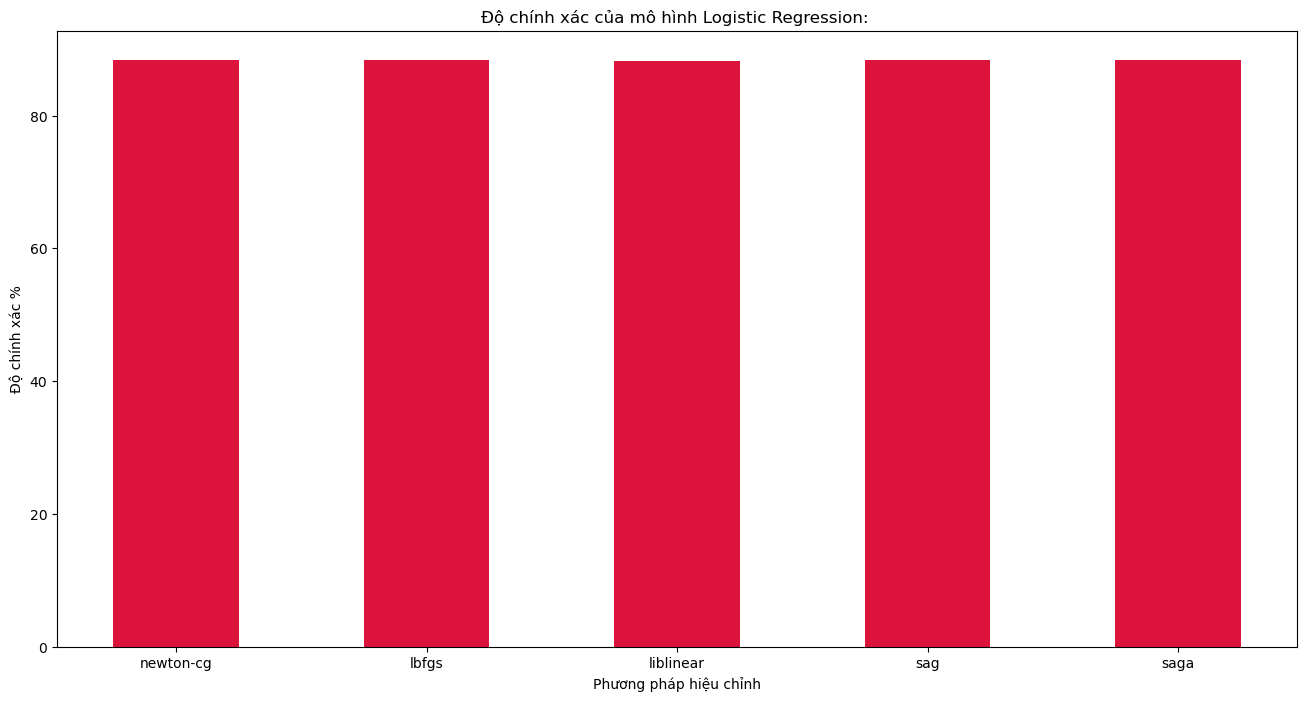

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))

plt.title("Độ chính xác của mô hình Logistic Regression: ")
plt.xlabel("Phương pháp hiệu chỉnh")
plt.ylabel("Độ chính xác %")
plt.bar(opt_solve, np.array(mean_accuracy_scores) * 100,color='crimson', width=0.5, label='Accuracy')
plt.savefig('image/lreg_accuracy.png', facecolor = 'whitesmoke')
plt.show()

In [ ]:
lreg_model = LogisticRegression(solver='saga',penalty='l2',C=2,max_iter=MAX_ITER)
lreg_model.fit(train_feature,y_train)
path = 'data/saved/lreg_model.sav'
pickle.dump(lreg_model, open(path, 'wb'))

### **3. Multinomial Naive Bayes**
Naive Bayes là một thuật toán phân lớp dựa trên định lý Bayes trong xác suất thông kê. Naive Bayes dựa trên 2 giả thuyết về dữ liệu đầu vào:
- Các đặc trưng của dữ liệu đầu vào là độc lập với nhau
- Các đặc trưng đầu vào có ảnh hưởng như nhau đối với đầu ra

Chính vì 2 giả thuyết này gần như không bao giờ tồn tại trong thực tế nên thuật toán này được coi là "ngây thơ". Tuy nhiên thuật toán này lại có tốc độ tính toán nhanh, dễ cài đặt và cũng hiệu quả trong 1 số trường hợp nhất định.

Multinomial Naive Bayes là loại thuật toán Naive Bayes hay được sử dụng với văn bản mà các vector được xây dựng dựa trên ý tưởng Bag-of-Words. Tuy nhiên với dữ liệu văn bản và bài toán phân loại chủ đề thì 2 giả thuyết của Naive Bayes là hoàn toàn không hợp lý. Bởi vì các từ trong một văn bản không hề độc lập với nhau và chúng cũng có ảnh hưởng khác nhau tới topic của văn bản. Vì vậy, mô hình này có thể sẽ cho kết quả không cao.

Siêu tham số mô hình: Trong mô hình Multinomial Naive Bayes có sử dụng kỹ thuật Laplace Smoothing để hạn chế trường hợp nếu 1 từ mới xuất hiện sẽ làm cho xác xuất tổng thể của một văn bản bằng 0 bất kể các từ phía sau xuất hiện nhiều thế nào. Hệ số làm mềm $\alpha$ là một số dương, khi $\alpha$ càng lớn thì các xác suất xuất hiện của các từ sẽ càng "mềm". Danh sách $\alpha$:

$$\alpha \in \{ 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 5, 8, 10 \}$$

In [ ]:
alphas = [0.0001, 0.001, 0.003, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 5]
mean_accuracy_scores = []
mean_f1_scores = []
mean_train_time = []
mean_valid_time = []
for a in alphas:
    # định nghĩa model
    model = MultinomialNB(alpha=a)

    accs = []
    f1s = []
    train_times = []
    valid_times = []

    for train_index, valid_index in spliter.split(x_train, y_train):
        # train model
        start = time.time_ns()
        model.fit(train_feature[train_index], y_train[train_index])
        train_times.append(time.time_ns() - start)

        # valid model
        start = time.time_ns()
        y_pred = model.predict(train_feature[valid_index])
        valid_times.append(time.time_ns() - start)

        # evaluate model
        accs.append(accuracy_score(y_train[valid_index], y_pred))
        f1s.append(f1_score(y_train[valid_index], y_pred, average='macro'))

    mean_train_time.append(np.mean(train_times))
    mean_valid_time.append(np.mean(valid_times))
    mean_accuracy_scores.append(np.mean(accs))
    mean_f1_scores.append(np.mean(f1s))

    print(f'Với alpha = {a}:')
    print('\t - Thời gian train: {:.2f} ms'.format(mean_train_time[-1] / 1e6))
    print('\t - Thời gian valid: {:.2f} ms'.format(mean_valid_time[-1] / 1e6))
    print('\t - Accuracy score:  {:.2f} %'.format(mean_accuracy_scores[-1] * 100))
    print('\t - F1 score:        {:.2f} %'.format(mean_f1_scores[-1] * 100))

Với alpha = 0.0001:
	 - Thời gian train: 544.93 ms
	 - Thời gian valid: 80.50 ms
	 - Accuracy score:  83.15 %
	 - F1 score:        81.45 %
Với alpha = 0.001:
	 - Thời gian train: 360.37 ms
	 - Thời gian valid: 65.71 ms
	 - Accuracy score:  84.02 %
	 - F1 score:        82.11 %
Với alpha = 0.003:
	 - Thời gian train: 328.00 ms
	 - Thời gian valid: 54.47 ms
	 - Accuracy score:  84.40 %
	 - F1 score:        82.50 %
Với alpha = 0.005:
	 - Thời gian train: 343.31 ms
	 - Thời gian valid: 63.30 ms
	 - Accuracy score:  84.67 %
	 - F1 score:        82.72 %
Với alpha = 0.01:
	 - Thời gian train: 333.55 ms
	 - Thời gian valid: 52.05 ms
	 - Accuracy score:  84.67 %
	 - F1 score:        82.31 %
Với alpha = 0.05:
	 - Thời gian train: 313.53 ms
	 - Thời gian valid: 54.51 ms
	 - Accuracy score:  81.78 %
	 - F1 score:        74.53 %
Với alpha = 0.1:
	 - Thời gian train: 381.68 ms
	 - Thời gian valid: 65.64 ms
	 - Accuracy score:  78.15 %
	 - F1 score:        66.15 %
Với alpha = 0.5:
	 - Thời gian train:

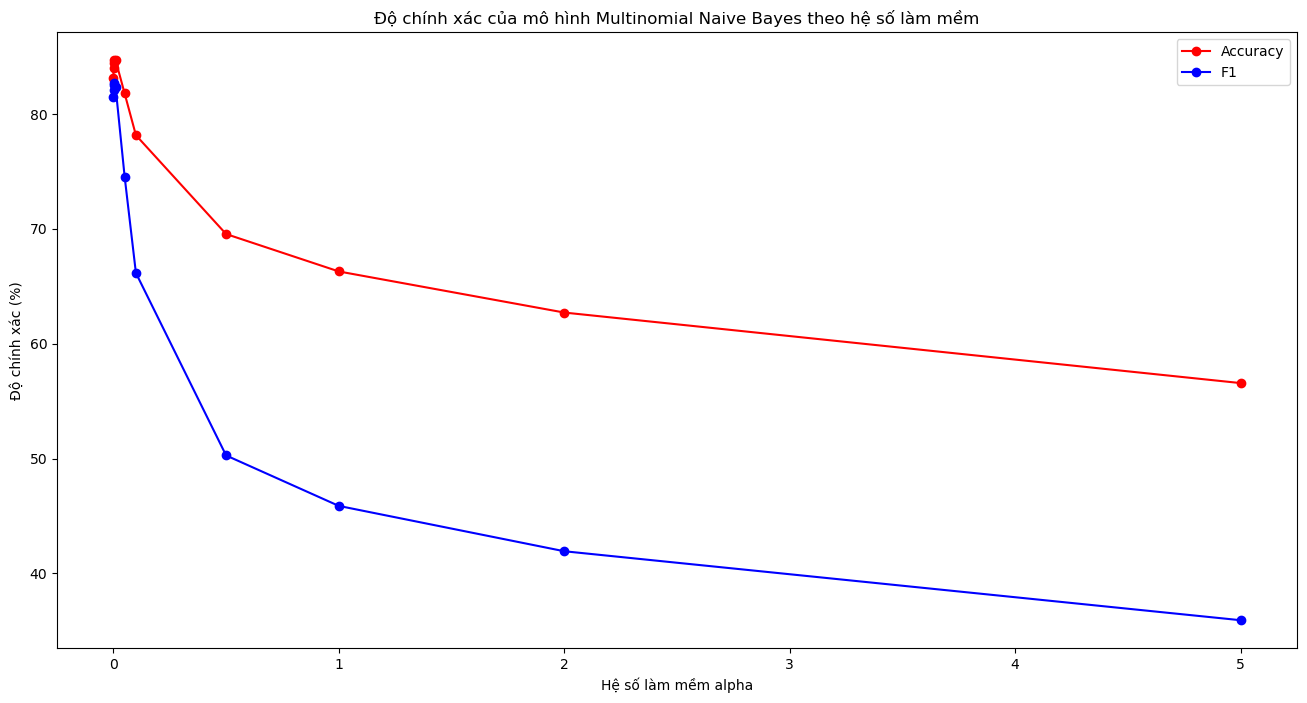

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 8))
plt.title('Độ chính xác của mô hình Multinomial Naive Bayes theo hệ số làm mềm')
plt.xlabel('Hệ số làm mềm alpha')
plt.ylabel('Độ chính xác (%)')
plt.plot(alphas, np.array(mean_accuracy_scores) * 100, 'ro-')
plt.plot(alphas, np.array(mean_f1_scores) * 100, 'bo-')
plt.legend(['Accuracy', 'F1'], loc='best')
plt.savefig('image/mnb_accuracy.png', facecolor='whitesmoke')
plt.show()

In [27]:
mnb = MultinomialNB(alpha=0.005)
pickle.dump(mnb,open('data/saved/mnb_model.sav','wb'))

### **4. Logistic Regression với PCA**

In [ ]:
mean_accuracy_scores = []
mean_f1_scores = []
mean_train_time = []
mean_valid_time = []

opt_solve = ['newton-cg','lbfgs','liblinear','sag','saga']
MAX_ITER = 100_000
for opt in opt_solve:
    model = LogisticRegression(solver=opt,penalty='l2',C=2,max_iter=MAX_ITER)
    accs = []
    f1s = []
    train_times = []
    valid_times = []
    for train_index, valid_index in spliter.split(x_train, y_train):
        # train model
        start = time.time_ns()
        model.fit(train_features_pca[train_index], y_train[train_index])
        train_times.append(time.time_ns() - start)

        # valid model
        start = time.time_ns()
        y_pred = model.predict(train_features_pca[valid_index])
        valid_times.append(time.time_ns() - start)

        # evaluate model
        accs.append(accuracy_score(y_train[valid_index], y_pred))
        f1s.append(f1_score(y_train[valid_index], y_pred, average='macro'))

    mean_train_time.append(np.mean(train_times))
    mean_valid_time.append(np.mean(valid_times))
    mean_accuracy_scores.append(np.mean(accs))
    mean_f1_scores.append(np.mean(f1s))
    print(f'Với phuong phap hieu chinh = {opt}:')
    print('\t - Thời gian train: {:.2f} ms'.format(mean_train_time[-1] / 1e6))
    print('\t - Thời gian valid: {:.2f} ms'.format(mean_valid_time[-1] / 1e6))
    print('\t - Accuracy score:  {:.2f} %'.format(mean_accuracy_scores[-1] * 100))
    print('\t - F1 score:        {:.2f} %'.format(mean_f1_scores[-1] * 100))

### *Đánh giá trên tập test*

In [28]:
mnb = pickle.load(open('data/saved/mnb_model.sav', 'rb'))
lreg = pickle.load(open('data/saved/lreg_model.sav', 'rb'))
#lreg_pca = pickle.load(open('Data/saved/lreg_pca_best.sav', 'rb'))

In [29]:
test_features = feature_extractor.fit_transform(x_test)

In [30]:
test_features = feature_extractor.transform(x_test)

test_features.shape

(9620, 62954)

In [36]:
start = time.time()
y_pred = mnb.predict(test_features)
print('Multinomial Naive Bayes')
print('Accuracy: {:.2f} %'.format(accuracy_score(y_test, y_pred) * 100))
print('F1 score: {:.2f} %'.format(f1_score(y_test, y_pred, average='macro') * 100))
print('Thời gian dự đoán: {:.2f} ms'.format((time.time() - start) * 1000))
print(confusion_matrix(y_test, y_pred))

ValueError: X has 62954 features, but MultinomialNB is expecting 94138 features as input.